In [39]:
import networkx as nx
from node2vec import Node2Vec
from igraph import Graph
import igraph as ig
import numpy as np
import json
import pandas as pd
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch_geometric.nn.models.autoencoder import ARGA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.metrics import precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import neptune
import os

In [40]:
node_list_path = r'C:\Users\George\Desktop\ISEF-2023\Datas\Node list\back up\current_protein_Signal+meta+targets.json'
with open(node_list_path, 'r') as file:
    node_list = json.load(file)
graph = r'C:\Users\George\Desktop\ISEF-2023\Network construction\PPI_homo_graph_features_loaded.graphml'
# Create an igraph object
PPI_graph = ig.Graph.Load(graph, format='graphml')

feature_keys = [
    "Indegree", "Outdegree", "Closeness", "Betweenness", "Pagerank", "Cluster_coefficients",
    "Nearest_Neighbor_Degree", "Similarity", "Subunit", "Transmembrane",
    "Catalytic_activity", "Interaction", "Tissue_Specificity", "Disease",
    "Sequence_conflict", "Modified_residue", "Function", "Binding_site",
    "Natural_variant", "Alternative_products", "Subcellular_location",
    "Active_site", "Disulfide_bond", "Mutagenesis", "PTM", "STP_involvement"
]

features = torch.tensor([
    PPI_graph.vs[key] for key in feature_keys
], dtype=torch.float).t()

edge_indices = torch.tensor(PPI_graph.get_edgelist(), dtype=torch.long).t()

# Assuming you have a label attribute in your graph
labels = torch.tensor(PPI_graph.vs["label"], dtype=torch.float)

# Create a PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_indices, y=labels)

print(data)

Data(x=[7392, 26], edge_index=[2, 49502], y=[7392])


C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\igraph\io\files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return reader(f, *args, **kwds)


In [41]:

data = train_test_split_edges(data)
print(data)

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[7392, 26], y=[7392], val_pos_edge_index=[2, 1237], test_pos_edge_index=[2, 2474], train_pos_edge_index=[2, 42062], train_neg_adj_mask=[7392, 7392], val_neg_edge_index=[2, 1237], test_neg_edge_index=[2, 2474])


In [42]:

class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, layer_channels):
        super(VEncoder, self).__init__()

        self.convs = torch.nn.ModuleList()

        # Add the input layer
        self.convs.append(GCNConv(in_channels, layer_channels[0], cached=True))

        # Add hidden layers
        for i in range(1, len(layer_channels)):
            self.convs.append(GCNConv(layer_channels[i-1], layer_channels[i], cached=True))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index).relu()
        return self.convs[-1](x, edge_index)
    

In [43]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [52]:
run = neptune.init_run(
    project="georgewang2008/ARGA",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNjU3MjQyMy0yZWUzLTQzNGYtOTI3MS0zNDNlYjJhOWQ3ZTgifQ==",
)

num_features = 26
epochs = 400
layer_channels = [52, 26]  # List of channel sizes for each layer
lr_d = 0.0001
lr_e = 0.0005

param = {
    'num_features':num_features,
    'epochs':epochs,
    'layer_channels':str(layer_channels),  # List of channel sizes for each layer
    'lr_d':lr_d,
    'lr_e':lr_e
}
run["parameters"] = param

encoder = VEncoder(in_channels=num_features, layer_channels=layer_channels)

discriminator = Discriminator(in_channels=layer_channels[-1], hidden_channels=52, 
                              out_channels=1) # Comment
model = ARGA(encoder, discriminator)

device = torch.device('cpu')
model, data = model.to(device), data.to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr_d)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr_e)

https://app.neptune.ai/georgewang2008/ARGA/e/ARGA-18


In [45]:
def train():
    num_nodes = data.x.shape[0]
    model.train()
    encoder_optimizer.zero_grad()
    
    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)  
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
 
    loss = 0
    loss = loss + model.reg_loss(z)  # Comment
    
    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    #loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()
    
    return loss

In [46]:
def test():
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred, average='weighted', zero_division=0)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi, precision, recall


In [53]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap, completeness, hm, nmi, precision, recall = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}'))

    run["train/loss"].append(loss)
    run["train/auc"].append(auc)
    run["train/ap"].append(ap)
    run["train/epoch"].append(epoch)
    run["train/completeness"].append(completeness)
    run["train/hm"].append(hm)
    run["train/nmi"].append(nmi) 
    run["train/Precision"].append(precision)
    run["train/Recall"].append(recall)

Epoch: 001, Loss: 56.630, AUC: 0.515, AP: 0.508, Completeness: 0.002, Homogeneity: 0.052, NMI: 0.004, Precision: 0.970, Recall: 0.371
Epoch: 002, Loss: 56.881, AUC: 0.516, AP: 0.508, Completeness: 0.002, Homogeneity: 0.052, NMI: 0.004, Precision: 0.970, Recall: 0.371
Epoch: 003, Loss: 57.026, AUC: 0.517, AP: 0.509, Completeness: 0.002, Homogeneity: 0.052, NMI: 0.004, Precision: 0.970, Recall: 0.371
Epoch: 004, Loss: 57.103, AUC: 0.519, AP: 0.510, Completeness: 0.002, Homogeneity: 0.052, NMI: 0.004, Precision: 0.970, Recall: 0.371
Epoch: 005, Loss: 57.100, AUC: 0.520, AP: 0.510, Completeness: 0.002, Homogeneity: 0.052, NMI: 0.004, Precision: 0.970, Recall: 0.371
Epoch: 006, Loss: 57.144, AUC: 0.520, AP: 0.510, Completeness: 0.002, Homogeneity: 0.052, NMI: 0.004, Precision: 0.970, Recall: 0.371
Epoch: 007, Loss: 57.081, AUC: 0.521, AP: 0.511, Completeness: 0.002, Homogeneity: 0.052, NMI: 0.004, Precision: 0.970, Recall: 0.371
Epoch: 008, Loss: 57.061, AUC: 0.522, AP: 0.511, Completeness:

In [54]:
def plot_points(colors, save_path):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.detach().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(2):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    
    plt.savefig(save_path, dpi=300)  # Save the plot as a PNG file with 300 dpi resolution
    
    plt.show()

C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\George\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


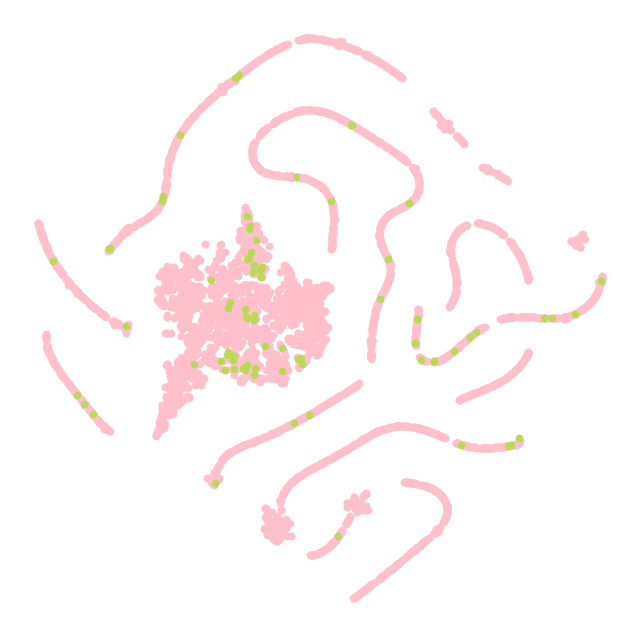

In [55]:
colors = [
    '#ffc0cb', '#bada55'
]
plot_points(colors, r'C:\Users\George\Desktop\ISEF-2023\Model\test\ARGA\embedded_plot.png')

In [57]:
import csv
node_names = PPI_graph.vs["name"]
z = model.encode(data.x, data.train_pos_edge_index)
csv_data = [["NodeName"] + [f"Feature_{i}" for i in range(z.shape[1])]]
model.eval()


for name, embedding in zip(node_names, z):
    row = [name] + embedding.tolist()
    csv_data.append(row)

print(csv_data)

csv_file_path = r'C:\Users\George\Desktop\ISEF-2023\Model\test\ARGA\latent_vector_embed.csv'

# Write the CSV file
with open(csv_file_path, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(csv_data)

print(f"CSV file saved at: {csv_file_path}")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CSV file saved at: C:\Users\George\Desktop\ISEF-2023\Model\test\ARGA\latent_vector_embed.csv
